In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datetime import timedelta

In [3]:
df = pd.read_csv("long_table_full.csv")

In [4]:
sub = df[["Date", "Ticker", "Return", "7D_Rolling_Mean", "7D_Rolling_Variance", "Volume"]]

In [5]:
sub = sub.sort_values(by=['Ticker', 'Date'])

sub['Return_Lag1'] = sub.groupby('Ticker')['Return'].shift(1)
sub['Volume_Lag1'] = sub.groupby('Ticker')['Volume'].shift(1)
sub = sub.sort_values(by=['Date','Ticker'])

In [6]:
sub

,Date,Ticker,Return,7D_Rolling_Mean,7D_Rolling_Variance,Volume,Return_Lag1,Volume_Lag1
0,2022-01-04,AEVA,-0.034641,NaN,NaN,-0.236455,NaN,NaN
1,2022-01-04,ATRO,0.068327,NaN,NaN,-0.596350,NaN,NaN
2,2022-01-04,DRD,-0.007335,NaN,NaN,0.652325,NaN,NaN
3,2022-01-04,GRPN,-0.015399,NaN,NaN,-0.682022,NaN,NaN
4,2022-01-04,NGVC,0.023417,NaN,NaN,0.537677,NaN,NaN
...,...,...,...,...,...,...,...,...
6003,2024-12-30,GRPN,0.012495,0.015736,0.002015,0.278188,-0.006683,-0.300515
6004,2024-12-30,NGVC,0.010384,0.005466,0.000347,-0.097638,-0.025636,-0.056512
6005,2024-12-30,RDFN,-0.032221,-0.001075,0.000798,0.322884,-0.014528,-0.276840
6006,2024-12-30,ROOT,0.005328,0.003229,0.000772,-0.331713,-0.041326,0.276707


In [7]:
macro = pd.read_csv("macro_merged.csv")

In [8]:
macro.DATE = pd.to_datetime(macro.DATE)
sub.Date = pd.to_datetime(sub.Date)

In [9]:
macro.rename(columns={"DATE":"Date"}, inplace = True)

In [10]:
macro.drop(columns= "Unnamed: 0", inplace = True)

In [11]:
merged = pd.merge(sub, macro, on = "Date", how = "left")

In [12]:
merged["Return_Binary"] = (merged.Return > 0)*1

In [13]:
merged

,Date,Ticker,Return,7D_Rolling_Mean,7D_Rolling_Variance,Volume,Return_Lag1,Volume_Lag1,Epi,CPI,FED_RATE,GDP,IPI,Return_Binary
0,2022-01-04,AEVA,-0.034641,NaN,NaN,-0.236455,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,0
1,2022-01-04,ATRO,0.068327,NaN,NaN,-0.596350,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,1
2,2022-01-04,DRD,-0.007335,NaN,NaN,0.652325,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,0
3,2022-01-04,GRPN,-0.015399,NaN,NaN,-0.682022,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,0
4,2022-01-04,NGVC,0.023417,NaN,NaN,0.537677,NaN,NaN,2.93,3.966999,0.08,21903.850,101.2146,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,2024-12-30,GRPN,0.012495,0.015736,0.002015,0.278188,-0.006683,-0.300515,2.35,3.746553,4.33,23542.349,103.1177,1
6004,2024-12-30,NGVC,0.010384,0.005466,0.000347,-0.097638,-0.025636,-0.056512,2.35,3.746553,4.33,23542.349,103.1177,1
6005,2024-12-30,RDFN,-0.032221,-0.001075,0.000798,0.322884,-0.014528,-0.276840,2.35,3.746553,4.33,23542.349,103.1177,0
6006,2024-12-30,ROOT,0.005328,0.003229,0.000772,-0.331713,-0.041326,0.276707,2.35,3.746553,4.33,23542.349,103.1177,1


In [14]:
df = merged.copy()

In [15]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

df = df.dropna(subset=["Return_Binary"])

# Define models
models = {
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "ENET": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,
                               max_iter=1000, random_state=42)
}

# Scoring metrics
scoring = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, zero_division=0),
    'Recall': make_scorer(recall_score, zero_division=0),
    'F1': make_scorer(f1_score, zero_division=0)
}

results = []

# Loop over each ticker
for ticker in df["Ticker"].unique():
    sub_df = df[df["Ticker"] == ticker].dropna().sort_values("Date").copy()

    # Drop target and ID columns
    X_all = sub_df.drop(columns=["Return", "Return_Binary", "Ticker", "Date"])
    y_all = sub_df["Return_Binary"]

    if len(X_all) < 100:
        continue

    # Time-based split: 70% train, 10% val, 20% test (test not used)
    n = len(X_all)
    train_end = int(n * 0.7)
    val_end = int(n * 0.8)

    X_train, y_train = X_all.iloc[:train_end], y_all.iloc[:train_end]
    X_val, y_val = X_all.iloc[train_end:val_end], y_all.iloc[train_end:val_end]

    row = {"Ticker": ticker}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        if name == "ENET":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model.fit(X_train_scaled, y_train)
            y_val_pred = model.predict(X_val_scaled)
        else:
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)

        row.update({
            f"{name}_Accuracy": accuracy_score(y_val, y_val_pred),
            f"{name}_Precision": precision_score(y_val, y_val_pred, zero_division=0),
            f"{name}_Recall": recall_score(y_val, y_val_pred, zero_division=0),
            f"{name}_F1": f1_score(y_val, y_val_pred, zero_division=0)
        })

    results.append(row)

# Combine and print results
results_df = pd.DataFrame(results)
print(results_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:37:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:37:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:37:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:37:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

  Ticker  RF_Accuracy  RF_Precision  RF_Recall     RF_F1  XGB_Accuracy  \
0   AEVA     0.613333      0.621622   0.605263  0.613333      0.560000   
1   ATRO     0.653333      0.642857   0.710526  0.675000      0.600000   
2    DRD     0.613333      0.680000   0.447368  0.539683      0.600000   
3   GRPN     0.613333      0.538462   0.656250  0.591549      0.520000   
4   NGVC     0.466667      0.461538   0.486486  0.473684      0.493333   
5   RDFN     0.640000      0.555556   0.500000  0.526316      0.546667   
6   ROOT     0.600000      0.750000   0.521739  0.615385      0.546667   
7   TDUP     0.640000      0.650000   0.666667  0.658228      0.506667   

   XGB_Precision  XGB_Recall    XGB_F1  ENET_Accuracy  ENET_Precision  \
0       0.571429    0.526316  0.547945       0.600000        0.600000   
1       0.590909    0.684211  0.634146       0.706667        0.681818   
2       0.681818    0.394737  0.500000       0.653333        0.687500   
3       0.450000    0.562500  0.500000   

/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:37:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


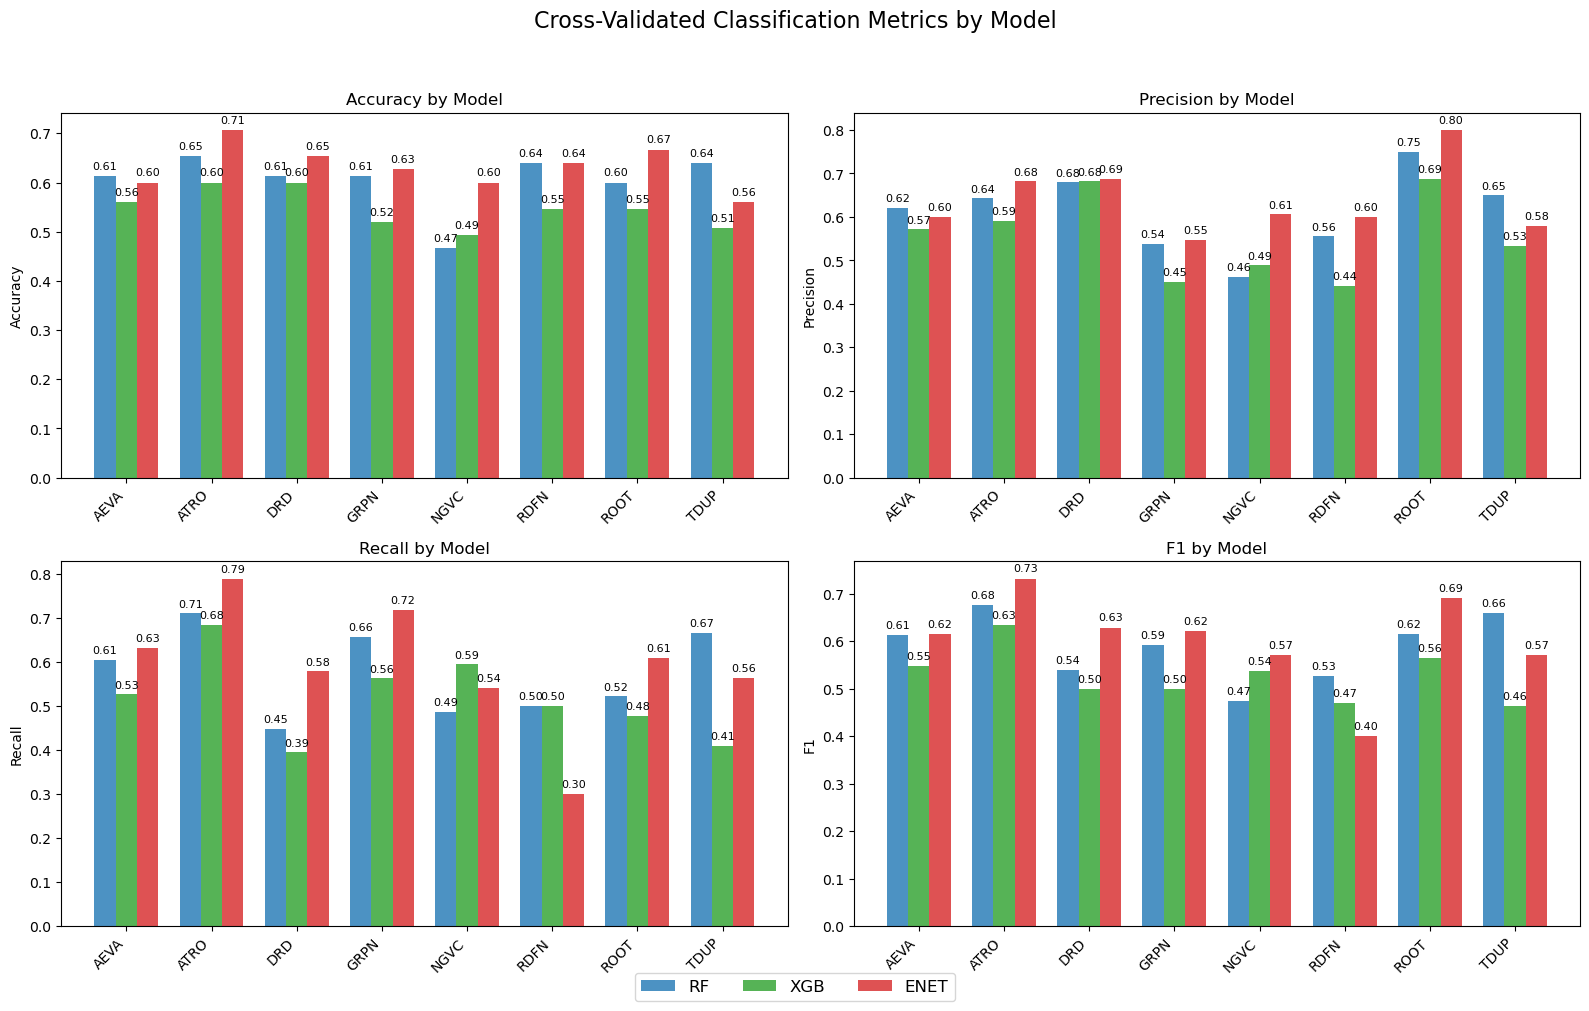

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing results_df
# results_df = pd.read_csv("your_results.csv")

# Plot setup
metrics = ["Accuracy", "Precision", "Recall", "F1"]
model_prefixes = ["RF", "XGB", "ENET"]
colors = {"RF": "tab:blue", "XGB": "tab:green", "ENET": "tab:red"}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

x = range(len(results_df))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bar_width = 0.25

    for i, model in enumerate(model_prefixes):
        offset = (i - 1) * bar_width  # shift bars left, center, right
        scores = results_df[f"{model}_{metric}"]
        bars = ax.bar(
            [xi + offset for xi in x],
            scores,
            width=bar_width,
            label=model,
            color=colors[model],
            alpha=0.8
        )

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    ax.set_title(f"{metric} by Model", fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["Ticker"], rotation=45, ha='right')

fig.suptitle("Cross-Validated Classification Metrics by Model", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(model_prefixes, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, -0.02))
plt.savefig("model.png", dpi = 300)
plt.show()

